In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import regex as re

from xlsx2csv import Xlsx2csv
from data_loading_utils import DataLoader

/Users/alexstanley/anaconda3/envs/dvhope_submission/lib/python3.10/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## Convert excel files to .csv

Raw data needed to be downloaded in .xlsx files. Convert them to csv so they can be easily read in pyspark. Save them in the same directory as original files

In [2]:
nonpoint_path = os.path.join('data', 'NEI_nonpointsource')

dl = DataLoader(nonpoint_path)
dl.xlsx_to_csv()

Converting NEI_SC_TN
NEI_SC_TN.csv already exists in data/NEI_nonpointsource
All Done!
Converting NEI_VT_WY
NEI_VT_WY.csv already exists in data/NEI_nonpointsource
All Done!
Converting NEI_DE_HI
NEI_DE_HI.csv already exists in data/NEI_nonpointsource
All Done!
Converting NEI_TX_UT
NEI_TX_UT.csv already exists in data/NEI_nonpointsource
All Done!
Converting NEI_ID_IA
NEI_ID_IA.csv already exists in data/NEI_nonpointsource
All Done!
Converting NEI_OH_RI
NEI_OH_RI.csv already exists in data/NEI_nonpointsource
All Done!
Converting NEI_MA_MS
NEI_MA_MS.csv already exists in data/NEI_nonpointsource
All Done!
Converting NEI_MT_NY
NEI_MT_NY.csv already exists in data/NEI_nonpointsource
All Done!
Converting NEI_KS_MD
NEI_KS_MD.csv already exists in data/NEI_nonpointsource
All Done!
Converting NEI_AL_CT
NEI_AL_CT.csv already exists in data/NEI_nonpointsource
All Done!


In [3]:
def spark_shape(sdf):
    print(f'N Rows: {sdf.count()}, N Cols: {len(sdf.columns)}')

In [4]:
from pyspark.sql import SparkSession

spark_df = dl.get_spark_dfs()

print(f'N Rows: {spark_df.count()}, N Cols: {len(spark_df.columns)}')
spark_df.printSchema()
spark_df.show(5)

24/11/24 22:44:12 WARN Utils: Your hostname, Alexs-MacBook-Pro-8.local resolves to a loopback address: 127.0.0.1; using 192.168.86.56 instead (on interface en0)
24/11/24 22:44:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/24 22:44:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


N Rows: 8337562, N Cols: 14
root
 |-- State: string (nullable = true)
 |-- State-County: string (nullable = true)
 |-- POLLUTANT: string (nullable = true)
 |-- Emissions (Tons): double (nullable = true)
 |-- Pollutant Type: string (nullable = true)
 |-- SCC Code: long (nullable = true)
 |-- EIS Sector: string (nullable = true)
 |-- Source Description: string (nullable = true)
 |-- SCC LEVEL 1: string (nullable = true)
 |-- SCC LEVEL 2: string (nullable = true)
 |-- SCC LEVEL 3: string (nullable = true)
 |-- SCC LEVEL 4: string (nullable = true)
 |-- EPA Region: string (nullable = true)
 |-- FIPS: string (nullable = true)

+------+------------+--------------------+----------------+--------------+----------+--------------------+------------------+--------------+--------------------+--------------------+--------------------+----------+-----+
| State|State-County|           POLLUTANT|Emissions (Tons)|Pollutant Type|  SCC Code|          EIS Sector|Source Description|   SCC LEVEL 1|         

In [5]:
# confirm that leading zero fill worked in loader function
spark_df.filter(spark_df['FIPS'] == '06005').select('FIPS').show(5)

+-----+
| FIPS|
+-----+
|06005|
|06005|
|06005|
|06005|
|06005|
+-----+
only showing top 5 rows



In [6]:
import pyspark.sql.functions as sqlfns

pollutants_sdf = spark_df.groupby(['FIPS', 'POLLUTANT']).agg(sqlfns.sum('Emissions (Tons)').alias('Total Emissions'))
pollutants_sdf.show(5)

+-----+--------------------+------------------+
| FIPS|           POLLUTANT|   Total Emissions|
+-----+--------------------+------------------+
|20031|             Ammonia|       1231.949655|
|20045|PM2.5 Primary (Fi...|       1129.992457|
|20171|     PM10 Filterable| 7414.633855000002|
|20027|       Nitrous Oxide|1.0586559999999998|
|20081|             Methane| 5.916785999999999|
+-----+--------------------+------------------+
only showing top 5 rows



In [7]:
spark_shape(pollutants_sdf)

N Rows: 317405, N Cols: 3


In [8]:
pollutants_df = pollutants_sdf.toPandas()
pollutants_df = pollutants_df.set_index(['FIPS', 'POLLUTANT']).unstack()

# may need to fill nan with zeroes, but tree based models should be able to handle nans
pollutants_df.head()

Total Emissions                        \
POLLUTANT 1,1,2,2-Tetrachloroethane 1,1,2-Trichloroethane   
FIPS                                                        
01001                           NaN                   NaN   
01003                           NaN                   NaN   
01005                           NaN                   NaN   
01007                           NaN                   NaN   
01009                           NaN                   NaN   

                                                                    \
POLLUTANT 1,2,4-Trichlorobenzene 1,3-Butadiene 1,3-Dichloropropene   
FIPS                                                                 
01001                        NaN     14.533101                 NaN   
01003                   0.000917     37.516182                 NaN   
01005                        NaN     47.521436                 NaN   
01007                        NaN     53.595436                 NaN   
01009                   0.000433      9.097771                 NaN   

                                                                        \
POLLUTANT 1,4-Dichlorobenzene 1-Methylnaphthalene 1-Methylphenanthrene   
FIPS                                                                     
01001                0.018476            0.023531             0.004250   
01003                0.033320            0.079303             0.016494   
01005                0.017095            0.015511             0.002492   
01007                0.011575            0.013034             0.001889   
01009                0.038974            0.031769             0.006261   

                                                 ...                 \
POLLUTANT 1-Methylpyrene 2,2,4-Trimethylpentane  ... Vinyl Chloride   
FIPS                                             ...                  
01001                NaN              15.184822  ...            NaN   
01003                NaN             170.984090  ...            NaN   
01005                NaN              20.654743  ...            NaN   
01007                NaN               6.338227  ...            NaN   
01009                NaN              13.855074  ...            NaN   

                                                          \
POLLUTANT Vinylidene Chloride Volatile Organic Compounds   
FIPS                                                       
01001                     NaN               21108.043719   
01003                0.001318               47575.536790   
01005                     NaN               30260.571759   
01007                     NaN               26741.919986   
01009                     NaN               20747.712025   

                                                                              \
POLLUTANT Xylenes (Mixed Isomers)  m-Xylene  o-Cresol o-Toluidine   o-Xylene   
FIPS                                                                           
01001                   36.249776  2.399304  0.056422         NaN   4.012007   
01003                  233.466395  9.726274  0.117265         NaN  13.766180   
01005                   41.271693  1.087843  0.413770         NaN   5.640353   
01007                   29.549518  0.966245  0.069205         NaN   6.251850   
01009                   32.780460  2.512328  1.118840         NaN   3.542811   

                               
POLLUTANT p-Dioxane  p-Xylene  
FIPS                           
01001           NaN  0.853697  
01003           NaN  3.489012  
01005           NaN  0.377064  
01007           NaN  0.336485  
01009           NaN  0.881514  

[5 rows x 159 columns]

In [9]:
# What are the biggest nonpoint source pollutants?
pollutants_df.sum().sort_values(ascending=False)

                 POLLUTANT                 
Total Emissions  Carbon Dioxide                2.145247e+09
                 Carbon Monoxide               6.104852e+07
                 Volatile Organic Compounds    4.213933e+07
                 PM10 Primary (Filt + Cond)    1.454193e+07
                 PM10 Filterable               1.126124e+07
                                                   ...     
                 Dimethyl Sulfate              1.312100e-02
                 Parathion                     1.211200e-02
                 Bromoform                     9.352000e-03
                 Epichlorohydrin               2.642000e-03
                 o-Toluidine                   3.940000e-04
Length: 159, dtype: float64

## Load Health Outcomes Data

In [10]:
health_df = pd.read_csv(os.path.join('data', 'PLACES__Local_Data_for_Better_Health__County_Data_2024_release_20241023.csv'), dtype={'LocationID':str})
health_df.head()

/var/folders/0b/l4__m5492hg2pxtxg6z149mh0000gn/T/ipykernel_1398/4147320094.py:1: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  health_df = pd.read_csv(os.path.join('data', 'PLACES__Local_Data_for_Better_Health__County_Data_2024_release_20241023.csv'), dtype={'LocationID':str})


,Year,StateAbbr,StateDesc,LocationName,DataSource,Category,Measure,Data_Value_Unit,Data_Value_Type,Data_Value,...,Low_Confidence_Limit,High_Confidence_Limit,TotalPopulation,TotalPop18plus,LocationID,CategoryID,MeasureId,DataValueTypeID,Short_Question_Text,Geolocation
0,2022,US,United States,NaN,BRFSS,Health Outcomes,Diagnosed diabetes among adults,%,Crude prevalence,12.0,...,11.8,12.2,333287557,260836730,59,HLTHOUT,DIABETES,CrdPrv,Diabetes,NaN
1,2022,AL,Alabama,Barbour,BRFSS,Disability,Hearing disability among adults,%,Crude prevalence,9.6,...,8.5,10.7,24706,19675,01005,DISABLT,HEARING,CrdPrv,Hearing Disability,POINT (-85.3928136383141 31.8698172860413)
2,2022,AL,Alabama,Calhoun,BRFSS,Health Outcomes,Stroke among adults,%,Age-adjusted prevalence,3.7,...,3.4,4.0,115788,91336,01015,HLTHOUT,STROKE,AgeAdjPrv,Stroke,POINT (-85.8257674379293 33.7714931264898)
3,2022,AL,Alabama,Chambers,BRFSS,Health Outcomes,Stroke among adults,%,Crude prevalence,5.6,...,5.1,6.0,34088,27025,01017,HLTHOUT,STROKE,CrdPrv,Stroke,POINT (-85.3917577489906 32.9141677822456)
4,2022,AL,Alabama,Clay,BRFSS,Health Outcomes,Stroke among adults,%,Crude prevalence,5.3,...,4.9,5.7,14198,11235,01027,HLTHOUT,STROKE,CrdPrv,Stroke,POINT (-85.8606604130173 33.2693085517833)


In [11]:
health_df.Measure.value_counts()

Diagnosed diabetes among adults                                                         6290
Visits to doctor for routine checkup within the past year among adults                  6290
Colorectal cancer screening among adults aged 45–75 years                               6290
Frequent mental distress among adults                                                   6290
Current cigarette smoking among adults                                                  6290
No leisure-time physical activity among adults                                          6290
Fair or poor self-rated health status among adults                                      6290
Chronic obstructive pulmonary disease among adults                                      6290
Independent living disability among adults                                              6290
Mammography use among women aged 50-74 years                                            6290
Vision disability among adults                                        

In [12]:
print(health_df.columns)

Index(['Year', 'StateAbbr', 'StateDesc', 'LocationName', 'DataSource',
       'Category', 'Measure', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value', 'Data_Value_Footnote_Symbol', 'Data_Value_Footnote',
       'Low_Confidence_Limit', 'High_Confidence_Limit', 'TotalPopulation',
       'TotalPop18plus', 'LocationID', 'CategoryID', 'MeasureId',
       'DataValueTypeID', 'Short_Question_Text', 'Geolocation'],
      dtype='object')


In [13]:
health_df.Category.value_counts()

Health Outcomes                75212
Disability                     44030
Prevention                     43762
Health-Related Social Needs    33852
Health Risk Behaviors          25160
Health Status                  18870
Name: Category, dtype: int64

In [14]:
health_df.Data_Value_Type.value_counts()

Crude prevalence           120443
Age-adjusted prevalence    120443
Name: Data_Value_Type, dtype: int64

## Exploratory Visualizations

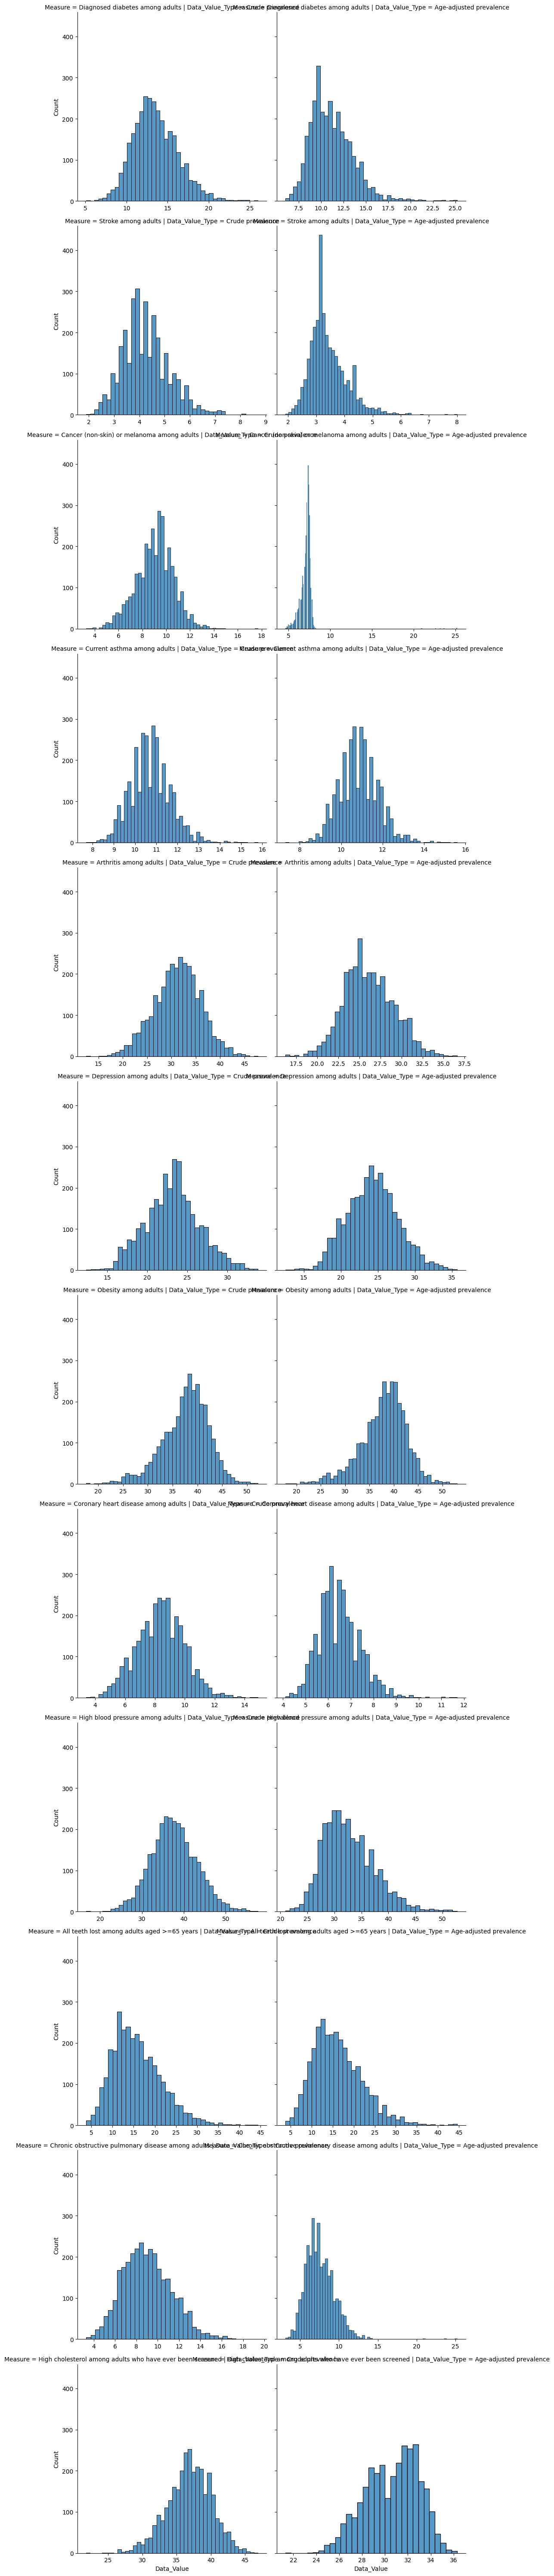

In [15]:
g = sns.FacetGrid(health_df[health_df.Category.isin(['Health Outcomes'])], row='Measure', col='Data_Value_Type', height=5, aspect=1, sharex=False)
g.map_dataframe(sns.histplot, 'Data_Value')
plt.show()

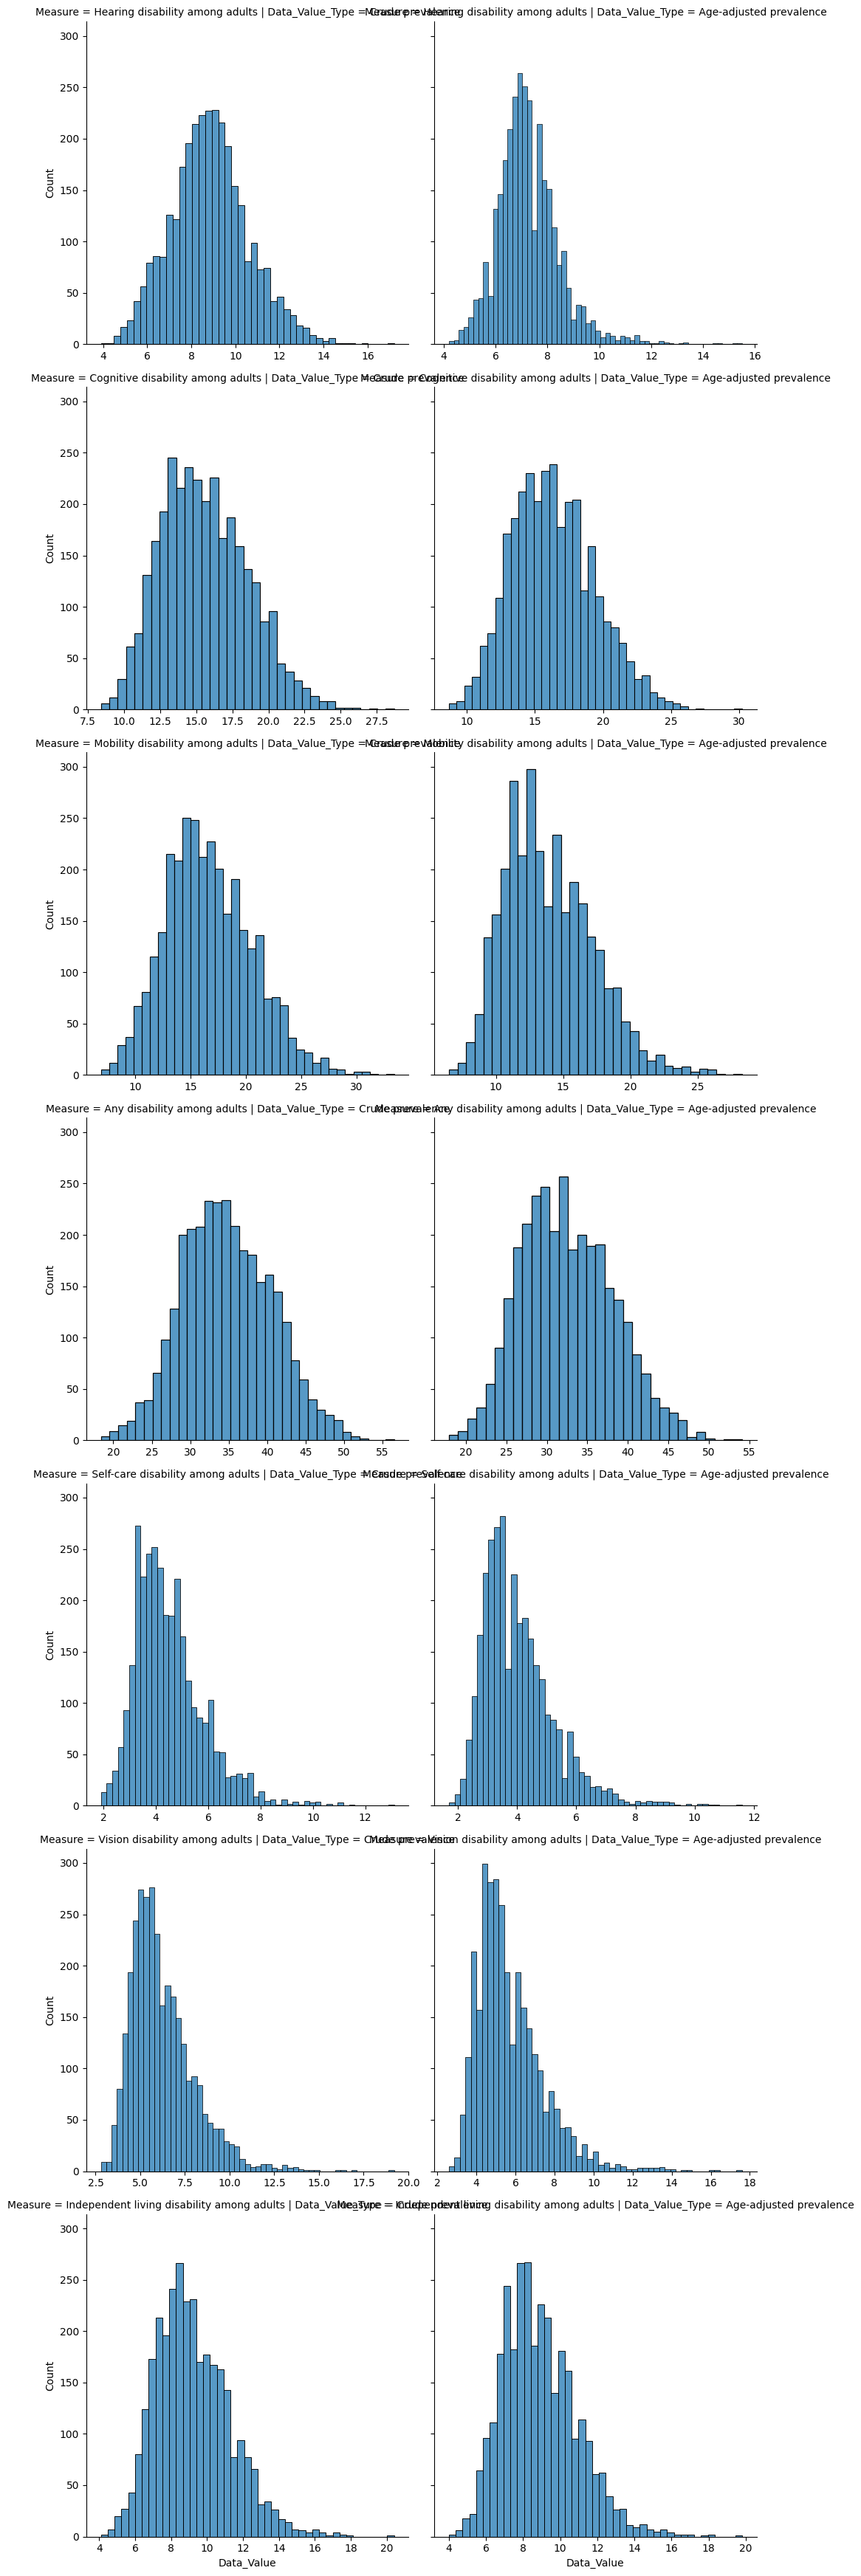

In [16]:
g = sns.FacetGrid(health_df[health_df.Category == 'Disability'], row='Measure', col='Data_Value_Type', height=5, aspect=1, sharex=False)
g.map_dataframe(sns.histplot, 'Data_Value')
plt.show()

<Axes: xlabel='Data_Value', ylabel='Measure'>

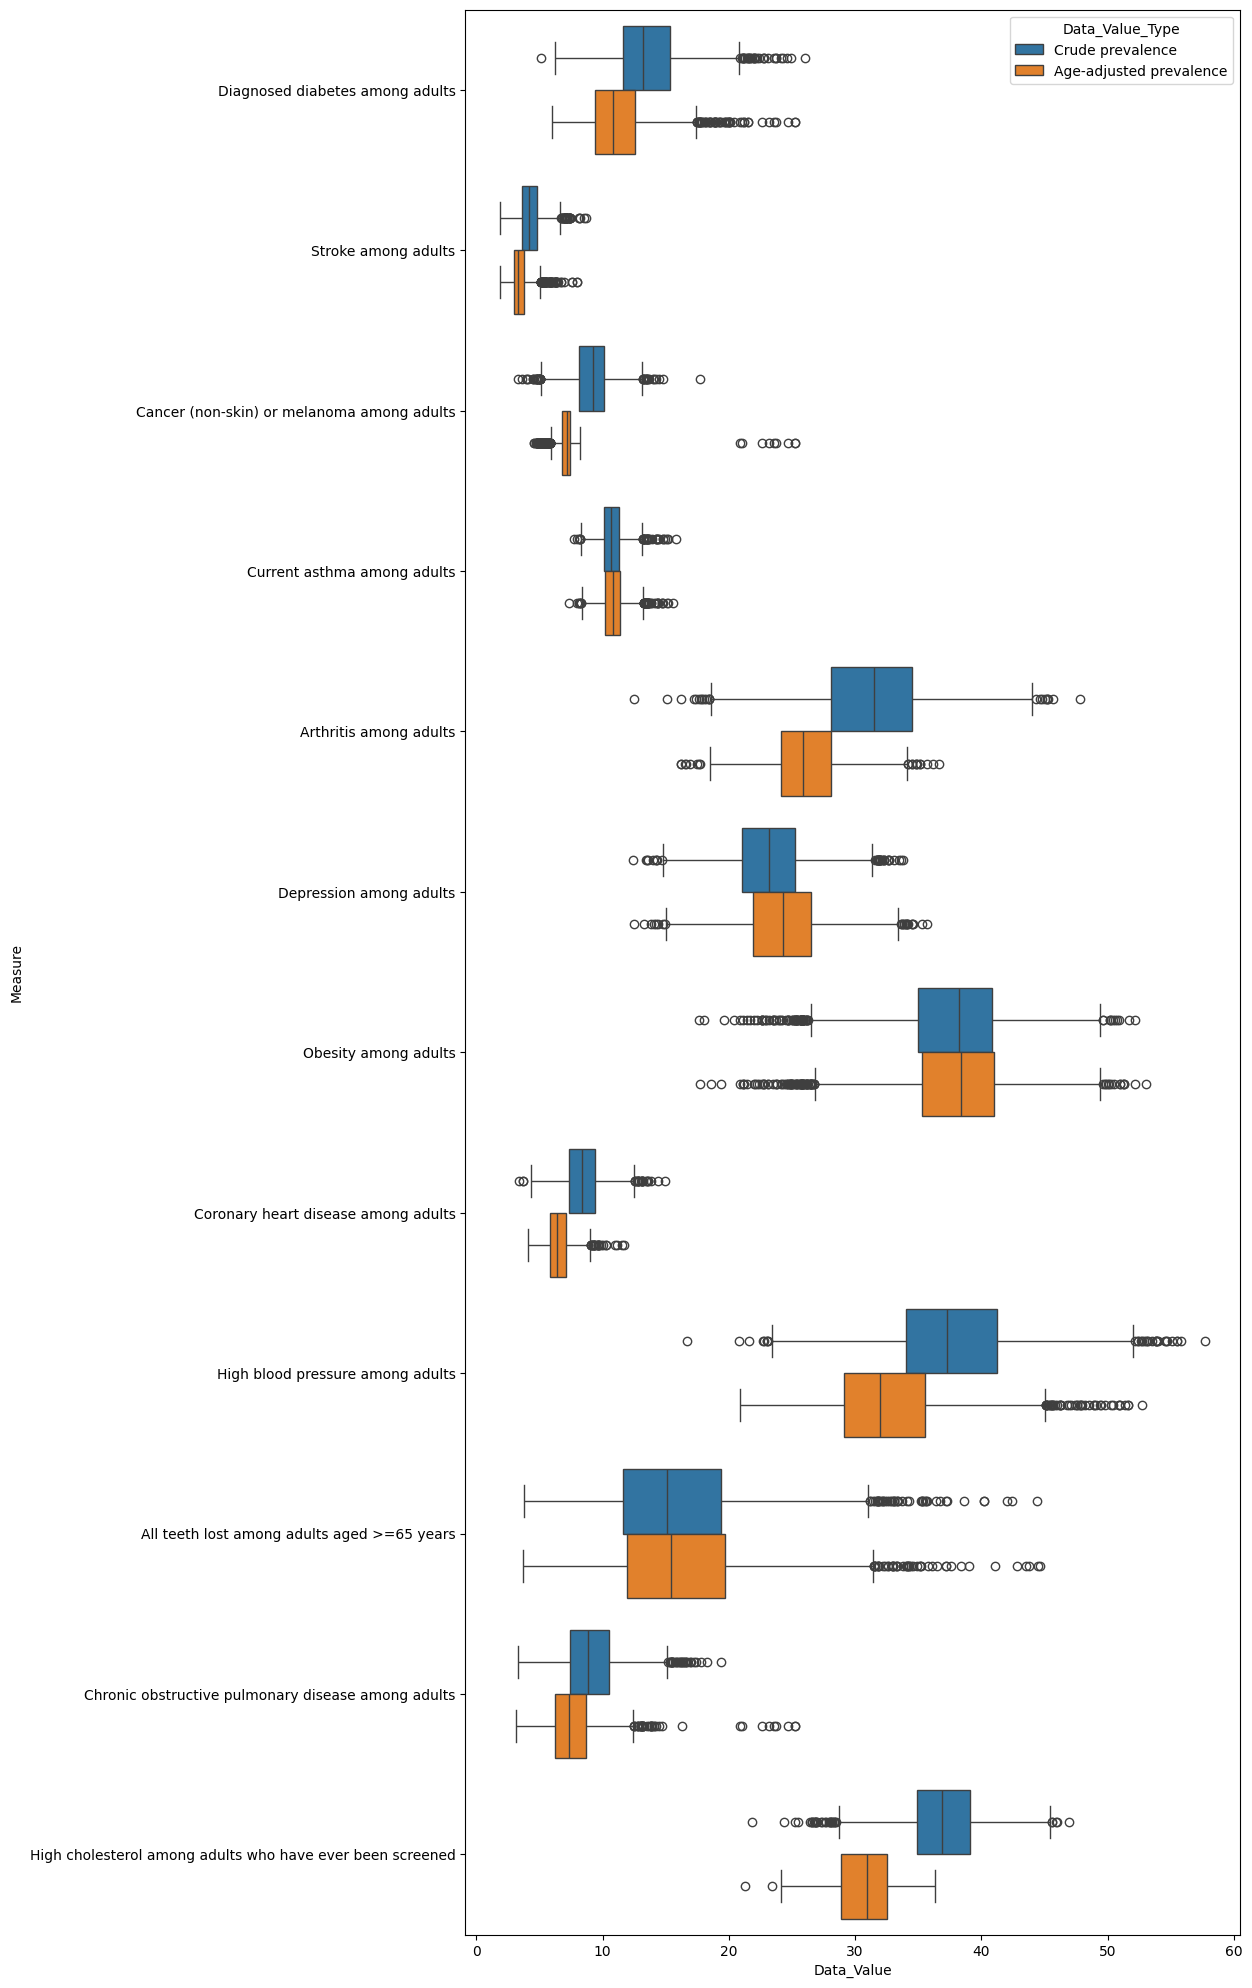

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10, 25))
sns.boxplot(health_df[health_df.Category == 'Health Outcomes'], y='Measure', hue='Data_Value_Type', x='Data_Value', ax=ax)

In [18]:
health_keep_cols = ['LocationID', 'StateDesc', 'Measure', 'Data_Value_Type', 'Data_Value_Unit', 'Data_Value']
merged_df = pollutants_df['Total Emissions'].merge(health_df.loc[:, health_keep_cols].set_index('LocationID'), left_index=True, right_index=True)
merged_df.head()

,"1,1,2,2-Tetrachloroethane","1,1,2-Trichloroethane","1,2,4-Trichlorobenzene","1,3-Butadiene","1,3-Dichloropropene","1,4-Dichlorobenzene",1-Methylnaphthalene,1-Methylphenanthrene,1-Methylpyrene,"2,2,4-Trimethylpentane",...,o-Cresol,o-Toluidine,o-Xylene,p-Dioxane,p-Xylene,StateDesc,Measure,Data_Value_Type,Data_Value_Unit,Data_Value
01001,NaN,NaN,NaN,14.533101,NaN,0.018476,0.023531,0.00425,NaN,15.184822,...,0.056422,NaN,4.012007,NaN,0.853697,Alabama,Mammography use among women aged 50-74 years,Crude prevalence,%,80.9
01001,NaN,NaN,NaN,14.533101,NaN,0.018476,0.023531,0.00425,NaN,15.184822,...,0.056422,NaN,4.012007,NaN,0.853697,Alabama,Cognitive disability among adults,Age-adjusted prevalence,%,14.1
01001,NaN,NaN,NaN,14.533101,NaN,0.018476,0.023531,0.00425,NaN,15.184822,...,0.056422,NaN,4.012007,NaN,0.853697,Alabama,Taking medicine to control high blood pressure...,Crude prevalence,%,81.3
01001,NaN,NaN,NaN,14.533101,NaN,0.018476,0.023531,0.00425,NaN,15.184822,...,0.056422,NaN,4.012007,NaN,0.853697,Alabama,Any disability among adults,Age-adjusted prevalence,%,31.1
01001,NaN,NaN,NaN,14.533101,NaN,0.018476,0.023531,0.00425,NaN,15.184822,...,0.056422,NaN,4.012007,NaN,0.853697,Alabama,Received food stamps in the past 12 months amo...,Crude prevalence,%,10.6


## Modeling


In [118]:
import math
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error

In [174]:
# should set seed globally for scikit learn
rndm_seed = 69
np.random.seed(rndm_seed)

train_test_kwargs = {'test_size': 0.15, 
                     'random_state':rndm_seed}

def get_train_test_splits(df: pd.DataFrame, measure: str, data_value_type: str, train_test_kwargs: dict=train_test_kwargs):
    """
    Filters supplied df and returns train test splits from filtered df

    Need to add later funcitonality to select specific X and y columns

    Returns X_train, X_test, y_train, y_test
    """
    filtered_df = df.loc[(df['Measure'] == measure) & \
                            (df['Data_Value_Type'] == data_value_type), :]

    filtered_df['StateDesc'] = filtered_df['StateDesc'].astype('category')

    # clean column names. They contain some unallowable chars [,],<
    filtered_df.columns = [re.sub(r'[\[\]\<]', '', col) for col in filtered_df.columns]

    # hard code predictor cols for now
    X = filtered_df.loc[:, :'StateDesc']
    y = filtered_df['Data_Value']

    return train_test_split(X, y, **train_test_kwargs)

cancer_df = merged_df.loc[(merged_df['Measure'] == 'Cancer (non-skin) or melanoma among adults') & \
                            (merged_df['Data_Value_Type'] == 'Age-adjusted prevalence'), :]

measure = 'Cancer (non-skin) or melanoma among adults'
data_val_type = 'Age-adjusted prevalence'

X_train, X_test, y_train, y_test = get_train_test_splits(merged_df, measure, data_val_type)
X_train

/var/folders/0b/l4__m5492hg2pxtxg6z149mh0000gn/T/ipykernel_97373/4139198671.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['StateDesc'] = filtered_df['StateDesc'].astype('category')


,"1,1,2,2-Tetrachloroethane","1,1,2-Trichloroethane","1,2,4-Trichlorobenzene","1,3-Butadiene","1,3-Dichloropropene","1,4-Dichlorobenzene",1-Methylnaphthalene,1-Methylphenanthrene,1-Methylpyrene,"2,2,4-Trimethylpentane",...,Vinylidene Chloride,Volatile Organic Compounds,Xylenes (Mixed Isomers),m-Xylene,o-Cresol,o-Toluidine,o-Xylene,p-Dioxane,p-Xylene,StateDesc
06079,NaN,NaN,NaN,26.405086,NaN,0.040863,0.451778,0.094477,NaN,40.318837,...,0.001006,52966.088474,51.974999,49.507501,15.132117,NaN,24.019872,NaN,2.265160,California
13033,NaN,NaN,NaN,14.458181,NaN,0.016427,0.015891,0.002607,0.208702,9.956387,...,NaN,25081.699584,20.714475,1.006385,10.712314,NaN,1.131095,NaN,0.522078,Georgia
15009,NaN,NaN,0.000252,17.044327,0.850147,0.001393,0.004468,0.000767,NaN,61.894216,...,0.001231,36940.358650,100.082085,6.788790,0.072903,NaN,11.185725,NaN,2.550615,Hawaii
56023,0.003911,0.002365,NaN,3.428682,0.001963,0.028157,0.193725,0.040154,NaN,16.541935,...,NaN,11559.028171,46.279811,1.912543,1.064766,NaN,1.371572,NaN,0.347729,Wyoming
40007,0.013658,0.008819,NaN,3.133409,0.007319,0.074010,0.006264,0.000435,NaN,2.778682,...,NaN,12588.165431,35.623423,0.248209,0.483718,NaN,0.904524,NaN,0.086815,Oklahoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
08065,NaN,NaN,NaN,0.708450,NaN,NaN,0.014374,0.002225,NaN,9.232186,...,NaN,2059.130065,9.338886,0.245307,0.029697,NaN,0.220396,NaN,0.063485,Colorado
48409,0.005118,0.021658,NaN,6.624862,0.002999,0.033108,0.007479,0.001150,NaN,21.944913,...,0.000448,9312.433030,42.350154,0.431777,0.621121,NaN,1.798261,NaN,0.153459,Texas
13121,NaN,NaN,0.003253,18.923726,NaN,0.010433,0.228322,0.047156,0.003594,187.460122,...,0.015870,26848.822126,437.267846,44.879218,0.099468,NaN,53.008051,0.000672,16.381892,Georgia
32003,NaN,NaN,0.003169,55.603169,NaN,0.012213,0.756125,0.158303,NaN,642.402378,...,0.015462,51867.097563,1047.651341,97.538487,0.172823,NaN,115.200956,0.000654,35.000507,Nevada


In [ ]:
# check column names
for col_name in X_train.columns:
    for c in col_name:
        if c in ['[', ']', '<']:
            print(col_name)

## XGBoost
The best boosted tree had training r2 of 0.99 and test r2 0.68, indicating overfitting, but an overall improvement over previous results with only point source data that had r2 ~ 0.40. This model also shows much more significant contributions from pollutants.

params found: {'booster': 'gbtree', 'eta': 0.1, 'gamma': 0, 'max_depth': 10, 'subsample': 1}

* could regularization improve overfitting?Play with the lambda/alpha params

In [191]:
scoring = {'r2': make_scorer(r2_score),
           'mse': make_scorer(mean_squared_error),
           'mae': make_scorer(mean_absolute_error)}

params = {'subsample':[.5, 1],
         'eta': [0.1,],
         'gamma': [0, 1,],
         #'lambda': [0.01, 1, 10],
         #'alpha': [0.01, 1, 10],
         'max_depth': [6, 10],
         'booster': ['gbtree', 'dart']}

XGB_Model = GridSearchCV(XGBRegressor(enable_categorical=True), params, scoring=scoring, cv=5, refit='mse', error_score='raise')
XGB_Model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    l...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'booster': ['gbtree', 'dart'], 'eta': [0.1],
                         'gamma': [0, 1], 'max_depth': [6, 10],
                         'subsample': [0.5, 1]},
             refit='mse',
             scoring={'mae': make_scorer(mean_absolute_error),
                      'mse': make_scorer(mean_squared_error),
                      'r2': make_scorer(r2_score)})

In [192]:
XGB_Model.best_score_

0.15202799434539052

In [271]:
def xgb_model_metrics(xgb, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    # Feature importance
    best_model = xgb.best_estimator_ if isinstance(xgb, GridSearchCV) else xgb
    
    feature_importances = pd.DataFrame(best_model.feature_importances_,
                                       index=X_train.columns,
                                       columns=['importance'])
    
    # Model Evaluation
    train_preds = best_model.predict(X_train)
    
    train_r2 = r2_score(y_train, train_preds)
    
    test_preds = best_model.predict(X_test)
    
    test_r2 = r2_score(y_test, test_preds)
    
    print(f'Training R2: {train_r2:.4f}')
    print(f'Test R2: {test_r2:.4f}')


    return feature_importances.sort_values('importance', ascending=False), train_r2, test_r2, 

    

In [272]:
xgb_model_metrics(XGB_Model)
                                   

Training R2: 0.9992
Test R2: 0.6788


(                         importance
 Ethylene Dibromide         0.070633
 StateDesc                  0.070477
 Phosphorus                 0.068183
 Isophorone                 0.067152
 Chrysene                   0.036252
 ...                             ...
 Bromoform                  0.000000
 o-Toluidine                0.000000
 Nitrobenzene               0.000000
 Parathion                  0.000000
 Pentachloronitrobenzene    0.000000
 
 [160 rows x 1 columns],
 0.9991891520460106,
 0.678812285023549)

In [200]:
XGB_Model.best_params_

{'booster': 'gbtree', 'eta': 0.1, 'gamma': 0, 'max_depth': 10, 'subsample': 1}

In [214]:
XGB_Model.best_score_

0.15202799434539052

In [235]:
# Save Model
best_model.save_model(os.path.join('saved_models', 'xgboost_nonpointsource.json'))

## Train a single Random Forest with no boosting

Random forest seems much less prone to overfitting, but overall performance is still worse than xgboost.

In [246]:
rf_params = {'subsample':[.5, 0.8],
             'colsample_bynode': [0.5, 0.8],
             'eta': [1],
             'gamma': [0, 1,],
             'max_depth': [6, 10],
             'num_parallel_tree': [10, 100],
             'objective': ['reg:squarederror'],
             'random_state': [rndm_seed]}

XGBRF_Model = GridSearchCV(XGBRFRegressor(enable_categorical=True), rf_params, scoring=scoring, cv=5, refit='mse', error_score='raise')
XGBRF_Model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRFRegressor(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=True, eval_metric=None,
                                      feature_types=None, gamma=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      max_bin=None, max_cat_...
                                      random_state=None, reg_alpha=None, ...),
             param_grid={'colsample_bynode': [0.5, 0.8], 'eta': [1],
                         'gamma': [0, 1], 'max_depth': [6, 10],
                         'num_parallel_tree': [10, 100],
                         'objective': ['reg:squarederror'],
                         'random_state': [69], 'subsample': [0.5, 0.8]},
             refit='mse',
             scoring={'mae': make_scorer(mean_absolute_error),
                      'mse': make_scorer(mean_squared_error),
                      'r2': make_scorer(r2_score)})

In [248]:
XGBRF_Model.best_score_

0.15154714646575945

In [250]:
XGBRF_Model.best_params_

{'colsample_bynode': 0.5,
 'eta': 1,
 'gamma': 1,
 'max_depth': 6,
 'num_parallel_tree': 10,
 'objective': 'reg:squarederror',
 'random_state': 69,
 'subsample': 0.5}

In [251]:
xgb_model_metrics(XGBRF_Model)

Training R2: 0.6875
Test R2: 0.6188


(                       importance
 2-Methylphenanthrene     0.037007
 1-Methylphenanthrene     0.033226
 StateDesc                0.032716
 Hydroquinone             0.023061
 Catechol                 0.022140
 ...                           ...
 Maleic Anhydride         0.000000
 Quinone                  0.000000
 N,N-Dimethylformamide    0.000000
 Nitrobenzene             0.000000
 Epichlorohydrin          0.000000
 
 [160 rows x 1 columns],
 0.6874543535126327,
 0.6187534061075035)

In [256]:
XGBRF_Model.best_estimator_.save_model(os.path.join('saved_models', 'xgbrf_nonpointsource.json'))

### Boosted RF 
XGB library allows for combining the previous two approaches: gradient boosted random forests! I don't think this works with the grid search function, though.

In [267]:
import xgboost as xgb

rfb_params = XGBRF_Model.best_params_

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
rfb_model = xgb.train(rfb_params, dtrain=dtrain_reg, num_boost_round=100)

In [280]:
rfb_train_preds = rfb_model.predict(dtrain_reg)


rfb_preds = rfb_model.predict(xgb.DMatrix(X_test, y_test, enable_categorical=True))


print(f'Train r2: {r2_score(y_train, rfb_train_preds):.4f}')
print(f'Test r2: {r2_score(y_test, rfb_preds):.4f}')

Train r2: 0.7978
Test r2: 0.6678


In [299]:
rfb_features = pd.DataFrame([rfb_model.get_score(importance_type='gain')]).T
rfb_features = rfb_features.rename(columns={0:'Feature Name'})
rfb_features.sort_values('Feature Name', ascending=False).iloc[:20]

,Feature Name
Catechol,20.174734
2-Methylphenanthrene,15.690583
1-Methylphenanthrene,13.252968
Methylene Chloride,8.704207
Diethanolamine,6.853117
Acetophenone,6.516198
Isophorone,6.285063
StateDesc,6.148081
Triethylamine,5.716646
Hydrogen Cyanide,5.451281


In [294]:
rfb_model.save_model(os.path.join('saved_models', 'boosted_randomforest'))

,0
"1,1,2,2-Tetrachloroethane",1.645653
"1,1,2-Trichloroethane",4.030600
"1,2,4-Trichlorobenzene",1.248393
"1,3-Butadiene",1.436849
"1,4-Dichlorobenzene",2.043112
...,...
m-Xylene,1.146867
o-Cresol,3.182470
o-Xylene,2.039273
p-Xylene,4.837303
